### Galaxy Zoo - The Galaxy Challenge

#### Author: Ching-Yin NG
#### Source code and report are available at https://github.com/alvinng4/GalaxyZooChallenge
#### Best model score: 0.07972
#### Best score after model averaging: 0.07716

Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses\
Q2. Is it edge-on? 2 responses\
Q3. Is there a bar? 2 responses\
Q4. Is there a spiral pattern? 2 responses\
Q5. How prominent is the central bulge? 4 responses\
Q6. Is there anything "odd" about the galaxy? 2 responses\
Q7. How round is the smooth galaxy? 3 responses\
Q8. What is the odd feature? 7 responses\
Q9. What shape is the bulge in the edge-on galaxy? 3 responses\
Q10. How tightly wound are the spiral arms? 3 responses\
Q11. How many spiral arms are there? 6 responses

In [1]:
import math
from pathlib import Path
import random
import timeit

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import polars
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

SUBCLASS_LEN = [3, 2, 2, 2, 4, 2, 3, 7, 3, 3, 6]
SUBCLASS_LEN_CUMSUM = np.cumsum(SUBCLASS_LEN)
CLASS_LEN = len(SUBCLASS_LEN)


RANDOM_STATE = 1
torch.manual_seed(RANDOM_STATE)

FILE_PREFIX = "test"
MODEL_DIR = Path(f"models/{FILE_PREFIX}")
IMAGE_DIR = Path("images")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

True


### Import dataset

In [2]:
data_folder = Path("../data")

img_path = data_folder / "images_training_rev1"
file_list = sorted([str(path) for path in img_path.glob('*.jpg')])
print(f"Number of data: {len(file_list)}")

train_sol_path = data_folder / "training_solutions_rev1" / "training_solutions_rev1.csv"
train_sol = polars.read_csv(train_sol_path)
print("Some labels: ")
print(train_sol.head())

soft_labels = train_sol[:, 1:].to_numpy()

one_hot_labels = np.argmax(soft_labels[:, :SUBCLASS_LEN_CUMSUM[0]], axis=1)    # Class one
for i in range(1, CLASS_LEN):
    one_hot_labels = np.vstack(
        (one_hot_labels, np.argmax(soft_labels[:, SUBCLASS_LEN_CUMSUM[i - 1]:SUBCLASS_LEN_CUMSUM[i]], axis=1))
    )
one_hot_labels = one_hot_labels.T
print(soft_labels)
print(soft_labels.shape)
print(one_hot_labels)
print(one_hot_labels.shape)

Number of data: 61578
Some labels: 
shape: (5, 38)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ GalaxyID ┆ Class1.1 ┆ Class1.2 ┆ Class1.3 ┆ … ┆ Class11.3 ┆ Class11.4 ┆ Class11.5 ┆ Class11.6 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 100008   ┆ 0.383147 ┆ 0.616853 ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.325512  │
│ 100023   ┆ 0.327001 ┆ 0.663777 ┆ 0.009222 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100053   ┆ 0.765717 ┆ 0.177352 ┆ 0.056931 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100078   ┆ 0.693377 ┆ 0.238564 ┆ 0.068059 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100090   ┆ 0.933839 ┆ 0.0      ┆ 0.066161 ┆ … ┆ 0.0       ┆ 0.0  

In [3]:
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        label = self.labels[index]

        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def __len__(self):
        return len(self.labels)
        
train_file_list, temp_file_list, train_soft_labels, temp_soft_labels =\
     train_test_split(file_list, soft_labels, test_size=0.1,
                      random_state=RANDOM_STATE, stratify=one_hot_labels[:, 0])

temp_one_hot_labels = np.argmax(temp_soft_labels[:, :3], axis=1)

valid_file_list, test_file_list, valid_soft_labels, test_soft_labels =\
     train_test_split(temp_file_list, temp_soft_labels, test_size=0.7,
                      random_state=RANDOM_STATE, stratify=temp_one_hot_labels)

transform_train = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.CenterCrop([256, 256]),
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.CenterCrop([256, 256]),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = ImageDataset(train_file_list, train_soft_labels, transform_train)
valid_dataset = ImageDataset(valid_file_list, valid_soft_labels, transform)
test_dataset = ImageDataset(test_file_list, test_soft_labels, transform)

print(f"Length of training files: {len(train_file_list)}")
print(f"Length of validation files: {len(valid_file_list)}")
print(f"Length of testing files: {len(test_file_list)}")

train_one_hot_labels_class_one = np.argmax(train_soft_labels[:, :3], axis=1)
valid_one_hot_labels_class_one = np.argmax(valid_soft_labels[:, :3], axis=1)
test_one_hot_labels_class_one = np.argmax(test_soft_labels[:, :3], axis=1)

print()
print("Class 1 distribution: ")
print(f"Training dataset: {Counter(train_one_hot_labels_class_one)}")
print(f"Validation dataset: {Counter(valid_one_hot_labels_class_one)}")
print(f"Testing dataset: {Counter(test_one_hot_labels_class_one)}")

Length of training files: 55420
Length of validation files: 1847
Length of testing files: 4311

Class 1 distribution: 
Training dataset: Counter({1: 31343, 0: 24024, 2: 53})
Validation dataset: Counter({1: 1045, 0: 800, 2: 2})
Testing dataset: Counter({1: 2438, 0: 1869, 2: 4})


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.67058825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.58431375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].
Clipping input data to the valid ran

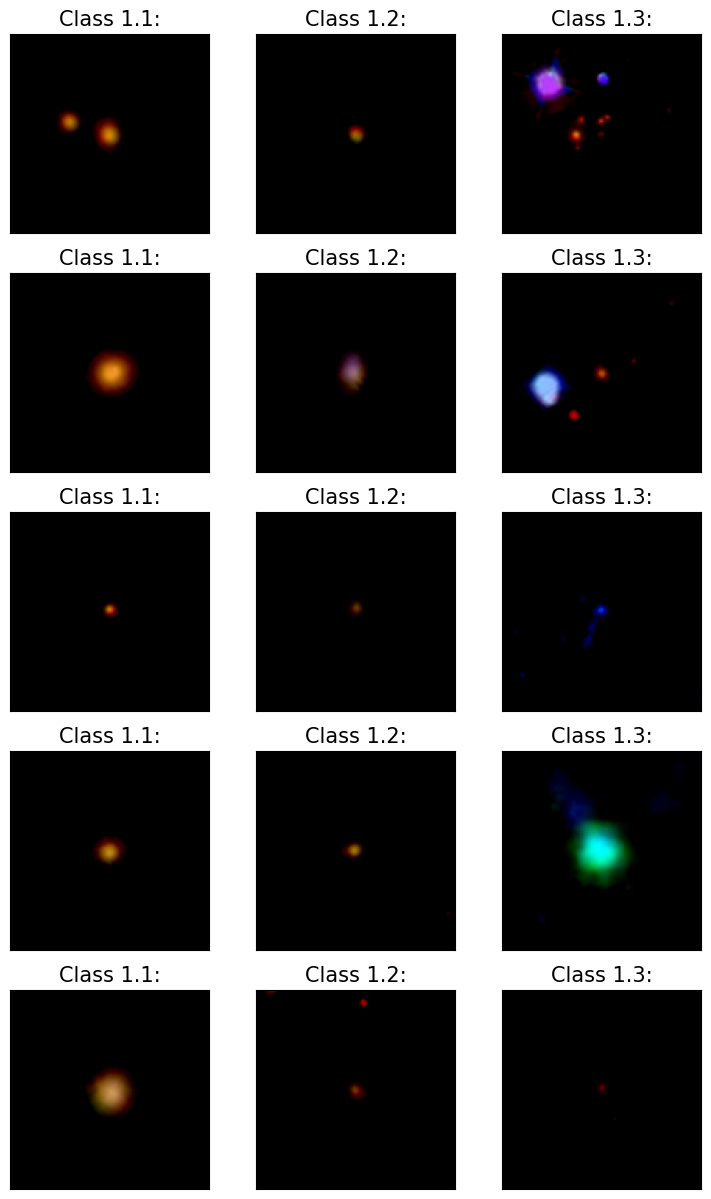

In [4]:
data_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)

img_class_zero = []
img_class_one = []
img_class_two = []
img_per_class = 5

iter_data_loader = iter(data_loader)
while True:
    img_batch, label_batch = next(iter_data_loader)
    for i in range(100):
        img = img_batch[i]
        label = label_batch[i]
        one_hot_label = np.argmax(label[:3])

        if (len(img_class_zero) < img_per_class) and (one_hot_label == 0):
            img_class_zero.append(img)
        elif (len(img_class_one) < img_per_class) and (one_hot_label == 1):
            img_class_one.append(img)
        elif (len(img_class_two) < img_per_class) and (one_hot_label == 2):
            img_class_two.append(img)
            
    if (
        (len(img_class_zero) >= img_per_class)
        and (len(img_class_one) >= img_per_class)
        and (len(img_class_two) >= img_per_class)
    ):
        break

fig1 = plt.figure(figsize=(9, 15))
for i in range(img_per_class):
    img = img_class_zero[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.1:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_one[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.2:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_two[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.3:', size=15)
    ax.imshow(img.permute(1, 2, 0))

plt.show()

### Creating a CNN-CBAM model

In [5]:
class channel_attention(nn.Module):
    def __init__(self, in_channels, reduction_ratio):
        super().__init__()
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        hidden_layer_size = int(in_channels // reduction_ratio)

        self.mlp = nn.Sequential()
        self.mlp.add_module("fc1", nn.Linear(in_channels, hidden_layer_size))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("fc2", nn.Linear(hidden_layer_size, in_channels))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled_map = self.max_pool(x)
        avg_pooled_map = self.avg_pool(x)

        max_att_map = self.mlp(self.flatten(max_pooled_map))
        avg_att_map = self.mlp(self.flatten(avg_pooled_map))

        cha_att_map = self.sigmoid(max_att_map + avg_att_map).unsqueeze(2).unsqueeze(3)

        return cha_att_map

class spatial_attention(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, padding=((kernel_size - 1) // 2))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled_map = torch.amax(x, dim=1, keepdim=True)
        avg_pooled_map = torch.mean(x, dim=1, keepdim=True)

        concat_pooled_map = torch.cat((max_pooled_map, avg_pooled_map), dim=1)
        conv_map = self.conv(concat_pooled_map)
        spa_att_map = self.sigmoid(conv_map)

        return spa_att_map

class CBAM(nn.Module):
    def __init__(self, in_channels, cha_att_reduction_ratio, spa_att_kernel_size):
        super().__init__()
        self.channel_attention_module = channel_attention(
            in_channels, cha_att_reduction_ratio
        )
        self.spatial_attention_module = spatial_attention(
            in_channels, spa_att_kernel_size
        )

    def forward(self, x):
        cha_att_map = self.channel_attention_module(x)
        spa_att_map = self.spatial_attention_module(x * cha_att_map)

        return x + (x * cha_att_map * spa_att_map)

In [6]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=17, padding=8))
model.add_module('bn1', nn.BatchNorm2d(num_features=32))
model.add_module('relu1', nn.ReLU())       
model.add_module('cbam1', CBAM(in_channels=32, cha_att_reduction_ratio=1, spa_att_kernel_size=7))
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
# model.add_module('dropout1', nn.Dropout2d(p=0.15))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=13, padding=6))
model.add_module('bn2', nn.BatchNorm2d(num_features=64))
model.add_module('relu2', nn.ReLU())        
model.add_module('cbam2', CBAM(in_channels=64, cha_att_reduction_ratio=1, spa_att_kernel_size=7))
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
# model.add_module('dropout2', nn.Dropout2d(p=0.15))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=9, padding=4))
model.add_module('bn3', nn.BatchNorm2d(num_features=128))
model.add_module('relu3', nn.ReLU())        
model.add_module('cbam3', CBAM(in_channels=128, cha_att_reduction_ratio=1, spa_att_kernel_size=7))
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
# model.add_module('dropout3', nn.Dropout2d(p=0.15))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, padding=3))
model.add_module('bn4', nn.BatchNorm2d(num_features=256))
model.add_module('relu4', nn.ReLU())
model.add_module('cbam4', CBAM(in_channels=256, cha_att_reduction_ratio=1, spa_att_kernel_size=7))

In [7]:
x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 256, 16, 16])


In [8]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=2)) 
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 16384])


In [9]:
model.add_module('fc1', nn.Linear(16384, 1024)) 
# model.add_module('bn5', nn.BatchNorm1d(num_features=1024))
# model.add_module('dropout4', nn.Dropout(p=0.2))

x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 1024])


In [10]:
model.add_module('fc2', nn.Linear(1024, SUBCLASS_LEN_CUMSUM[-1]) )
model.add_module('sigmoid', nn.Sigmoid())

x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 37])


In [11]:
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (cbam1): CBAM(
    (channel_attention_module): channel_attention(
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (mlp): Sequential(
        (fc1): Linear(in_features=32, out_features=32, bias=True)
        (relu): ReLU()
        (fc2): Linear(in_features=32, out_features=32, bias=True)
      )
      (sigmoid): Sigmoid()
    )
    (spatial_attention_module): spatial_attention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (sigmoid): Sigmoid()
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6))
  (bn2): BatchNorm2d(64, eps=1e

In [12]:
model = model.to(device)

### Training

In [13]:
hist = [[], [], [], []]
lr_hist = []

In [14]:
from sklearn.metrics import mean_squared_error

def train(model, num_epochs, lr_scheduler, optimizer, train_dl, valid_dl, batch_size, hist, lr_hist, save_every_n_epochs):
    loss_fn = nn.BCELoss()
    previous_epochs = len(hist[0])
    
    for epoch in range(num_epochs):
        start = timeit.default_timer()
        model.train()
        i = 0
        loss_hist_train = 0
        rmse_hist_train = 0
        for x_batch, y_batch in train_dl:
            i += 1
            if i % 5 == 0:
                print(f"Progress: epoch: {previous_epochs + epoch + 1}/{previous_epochs + num_epochs}, batch: {i}/{len(train_dl)}", end="\r")
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred.float(), y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train += loss.item() * y_batch.size(0)
            rmse_hist_train += mean_squared_error(y_true=y_batch.cpu(), y_pred=pred.detach().cpu())

        loss_hist_train /= len(train_dl.dataset)
        rmse_hist_train /= (len(train_dl.dataset) / batch_size)
        rmse_hist_train = math.sqrt(rmse_hist_train)
        
        model.eval()
        loss_hist_valid = 0
        rmse_hist_valid = 0
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred.float(), y_batch.float())
                
                loss_hist_valid += loss.item() * y_batch.size(0)
                rmse_hist_valid += mean_squared_error(y_true=y_batch.cpu(), y_pred=pred.detach().cpu())

        loss_hist_valid /= len(valid_dl.dataset)
        rmse_hist_valid /= (len(valid_dl.dataset) / batch_size)
        rmse_hist_valid = math.sqrt(rmse_hist_valid)

        end = timeit.default_timer()

        print_str = (
            f"Epoch: {previous_epochs + epoch + 1} " +
            f"train rmse: {rmse_hist_train:.4f} " +
            f"train loss: {loss_hist_train:.4f} " +
            f"val rmse: {rmse_hist_valid:.4f} " +
            f"val loss: {loss_hist_valid:.4f} " +
            f"lr: {lr_scheduler.get_last_lr()[0]} " +
            f"Time taken: {end - start:.3f}s"
        )
        print(print_str)

        if (previous_epochs + epoch + 1) % save_every_n_epochs == 0:
            torch.save(model, MODEL_DIR / (FILE_PREFIX + f"_epoch{previous_epochs + epoch + 1}.pth"))

        results = [loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid]
        for i in range(len(hist)):
            hist[i].append(results[i])
        lr_hist.append(lr_scheduler.get_last_lr()[0])

        lr_scheduler.step()

In [15]:
# Ensure that the minority class appears in each (n) batch
from operator import itemgetter

n = 10

counter = Counter(train_one_hot_labels_class_one)
min_key, min_count = min(counter.items(), key=itemgetter(1))
batch_size = round(sum(counter.values()) / (min_count * n))
print(batch_size)

105


In [16]:
num_workers = 8    # num_workers must set to zero if the images are already transferred to the GPU

if num_workers == 0:
    train_dl = DataLoader(train_dataset, batch_size, num_workers=0, shuffle=True)
    valid_dl = DataLoader(valid_dataset, batch_size, num_workers=0, shuffle=False)
else:
    train_dl = DataLoader(train_dataset, batch_size, num_workers=num_workers, persistent_workers=True, pin_memory=True, shuffle=True)
    valid_dl = DataLoader(valid_dataset, batch_size, num_workers=num_workers, persistent_workers=True, pin_memory=True, shuffle=False)

/home/user/cyng/.conda/envs/galaxy_zoo/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

learning_rate = 0.0001

optimizer = Adam(model.parameters(), lr=learning_rate)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=60, T_mult=3, eta_min=1e-8)

In [18]:
num_epochs = 240
save_every_n_epochs = 10

train(model, num_epochs, lr_scheduler, optimizer,\
      train_dl, valid_dl, batch_size, hist, lr_hist, save_every_n_epochs)

/home/user/cyng/.conda/envs/galaxy_zoo/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 train rmse: 0.1303 train loss: 0.2646 val rmse: 0.1244 val loss: 0.2594 lr: 0.0001 Time taken: 86.574s
Epoch: 2 train rmse: 0.1121 train loss: 0.2497 val rmse: 0.1235 val loss: 0.2587 lr: 9.993148359005491e-05 Time taken: 82.500s
Epoch: 3 train rmse: 0.1069 train loss: 0.2460 val rmse: 0.1078 val loss: 0.2478 lr: 9.972612215893683e-05 Time taken: 83.103s
Epoch: 4 train rmse: 0.1038 train loss: 0.2439 val rmse: 0.1241 val loss: 0.2587 lr: 9.938447858805392e-05 Time taken: 82.590s
Epoch: 5 train rmse: 0.1011 train loss: 0.2421 val rmse: 0.1346 val loss: 0.2753 lr: 9.890748929868662e-05 Time taken: 83.173s
Epoch: 6 train rmse: 0.0998 train loss: 0.2412 val rmse: 0.1023 val loss: 0.2446 lr: 9.829646168532197e-05 Time taken: 82.304s
Epoch: 7 train rmse: 0.0983 train loss: 0.2402 val rmse: 0.1186 val loss: 0.2586 lr: 9.755307053217622e-05 Time taken: 83.378s
Epoch: 8 train rmse: 0.0969 train loss: 0.2393 val rmse: 0.1083 val loss: 0.2483 lr: 9.66793534227276e-05 Time taken: 83.574s


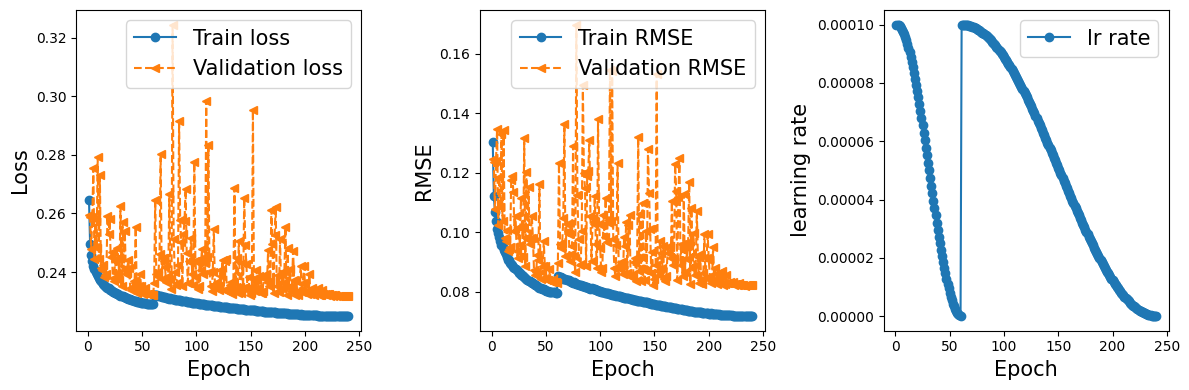

In [19]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 3, 2)
ax.plot(x_arr, hist[2], '-o', label='Train RMSE')
ax.plot(x_arr, hist[3], '--<', label='Validation RMSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('RMSE', size=15)

ax = fig.add_subplot(1, 3, 3)
ax.plot(x_arr, lr_hist, '-o', label='lr rate')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('learning rate', size=15)


plt.tight_layout()
plt.savefig(IMAGE_DIR / f"{FILE_PREFIX}_{learning_rate}.png")
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, root_mean_squared_error

test_dl = DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=False)

print("Getting test results from model...")
model.eval()
with torch.no_grad():
    all_preds_soft_labels = np.zeros((len(test_dataset), SUBCLASS_LEN_CUMSUM[-1]))
    all_soft_labels = np.zeros((len(test_dataset), SUBCLASS_LEN_CUMSUM[-1]))
    i = 0
    for x_batch, y_batch in test_dl:
        print(f"Progress: {i} / {len(test_dataset)}", end="\r")
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 

        all_preds_soft_labels[i: (i + batch_size)] = model(x_batch).cpu()
        all_soft_labels[i: (i + batch_size)] = y_batch.cpu()

        i += batch_size

all_preds_one_hot_labels_class_one = np.argmax(all_preds_soft_labels[:, :3], axis=1)
all_one_hot_labels_class_one = np.argmax(all_soft_labels[:, :3], axis=1)

rmse = root_mean_squared_error(all_soft_labels, all_preds_soft_labels)
rmse_per_column = np.zeros(all_soft_labels.shape[1])
for i in range(all_soft_labels.shape[1]):
    rmse_per_column[i] = root_mean_squared_error(all_soft_labels[:, i], all_preds_soft_labels[:, i])

print()
print(f"RMSE: {rmse}")
print(f"RMSE per column: {rmse_per_column}")
print()
print("Class one:")
print(f"Confusion matrix: \n{confusion_matrix(all_one_hot_labels_class_one, all_preds_one_hot_labels_class_one, labels=[0, 1, 2])}")
print(classification_report(all_one_hot_labels_class_one, all_preds_one_hot_labels_class_one, labels=[0, 1, 2]))

Getting test results from model...
Progress: 4305 / 4311
RMSE: 0.07233613375313488
RMSE per column: [0.12127758 0.12523661 0.02618596 0.06790665 0.12877923 0.08897788
 0.13533405 0.12320347 0.13359199 0.05276914 0.10098131 0.10867855
 0.0480738  0.10295    0.10294911 0.08077098 0.09145239 0.04506068
 0.05132084 0.02392974 0.04023754 0.04965792 0.05608013 0.05139762
 0.02122054 0.06240107 0.02566747 0.04510316 0.08944829 0.07761564
 0.05801102 0.04670303 0.09985872 0.05220067 0.02997015 0.03013929
 0.08129472]

Class one:
Confusion matrix: 
[[1658  211    0]
 [ 306 2132    0]
 [   0    2    2]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1869
           1       0.91      0.87      0.89      2438
           2       1.00      0.50      0.67         4

    accuracy                           0.88      4311
   macro avg       0.92      0.75      0.81      4311
weighted avg       0.88      0.88      0.88      4311



### Test submission

In [21]:
final_test_img_path = data_folder / "images_test_rev1"
final_test_file_list = sorted([str(path) for path in final_test_img_path.glob('*.jpg')])
print(f"Number of test files: {len(final_test_file_list)}")

Number of test files: 79975


In [22]:
class FinalTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        gxy_id = Path(file).stem
        
        return image, gxy_id
    
    def __len__(self):
        return len(self.file_list)

final_test_dataset = FinalTestImageDataset(final_test_file_list, transform)
final_test_dl = DataLoader(final_test_dataset, num_workers=8, persistent_workers=True, batch_size=1000, shuffle=False)

/home/user/cyng/.conda/envs/galaxy_zoo/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
import csv

with open("submission.csv", "w", newline="") as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow([
        "GalaxyID", "Class1.1", "Class1.2", "Class1.3", "Class2.1", "Class2.2", 
        "Class3.1", "Class3.2", "Class4.1", "Class4.2", "Class5.1", "Class5.2", 
        "Class5.3", "Class5.4", "Class6.1", "Class6.2", "Class7.1", "Class7.2", 
        "Class7.3", "Class8.1", "Class8.2", "Class8.3", "Class8.4", "Class8.5", 
        "Class8.6", "Class8.7", "Class9.1", "Class9.2", "Class9.3", "Class10.1", 
        "Class10.2", "Class10.3", "Class11.1", "Class11.2", "Class11.3", "Class11.4", 
        "Class11.5", "Class11.6"
    ])

    print("Getting test results from model...")
    model.eval()
    all_preds_soft_labels = np.zeros((len(final_test_dataset), SUBCLASS_LEN_CUMSUM[-1]))
    gxy_ids = np.zeros((len(final_test_dataset),))
    i = 0
    with torch.no_grad():
        for img_batch, gxy_id_batch in final_test_dl:
            print(f"Progress: {i + 1} / {len(all_preds_soft_labels)}", end="\r")
            img_batch = img_batch.to(device) 
            pred = model(img_batch)
            pred_soft_labels = pred.cpu().numpy()

            if len(pred_soft_labels) == 1000:
                all_preds_soft_labels[i: (i + 1000)] = pred_soft_labels
                gxy_ids[i: (i + 1000)] = gxy_id_batch
                i += 1000
            else:
                all_preds_soft_labels[i:] = pred_soft_labels
                gxy_ids[i: ] = gxy_id_batch
                i += len(pred_soft_labels)
                break

    print()
    print("Writing test results to submission file...")
    for i in range(len(all_preds_soft_labels)):
        print(f"Progress: {i + 1} / {len(all_preds_soft_labels)}", end="\r")
        output_list = [int(gxy_ids[i])] + all_preds_soft_labels[i].tolist()
        writer.writerow(output_list)

    print()
    print("Done!")

Getting test results from model...
Progress: 79001 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!


In [30]:
from pytorchsummary import summary

summary(model=model, input_size=(3, 128, 128))

for name, param in model.named_parameters():
    print(f"Parameter: {name}, Mean: {param.data.mean().item()}")

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Conv2d-1	[1, 32, 128, 128]   	  [32, 3, 17, 17]   	27776               	(27744 + 32)        	True True 
       BatchNorm2d-2	[1, 32, 128, 128]   	        [32]        	64                  	(32 + 32)           	True True 
              ReLU-3	[1, 32, 128, 128]   	                    	                    	                    	          
 AdaptiveMaxPool2d-4	[1, 32, 1, 1]       	                    	                    	                    	          
 AdaptiveAvgPool2d-5	[1, 32, 1, 1]       	                    	                    	                    	          
           Flatten-6	[1, 32]             	                    	                    	                    	          
            Linear-7	[1, 32]      

[Conv2d(3, 32, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8)), CBAM(
  (channel_attention_module): channel_attention(
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mlp): Sequential(
      (fc1): Linear(in_features=32, out_features=32, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
    )
    (sigmoid): Sigmoid()
  )
  (spatial_attention_module): spatial_attention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (sigmoid): Sigmoid()
  )
)]


100%|████| 1/1 [00:00<00:00, 22.77it/s]


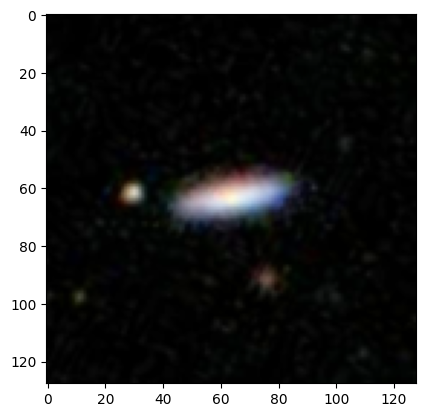

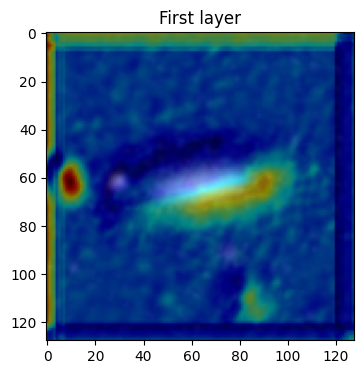

In [33]:
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.conv1, model.cbam1]
print(target_layers)

cam = AblationCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=transform(Image.open("../data/images_test_rev1/100037.jpg")).unsqueeze(0))

resize = transforms.Resize((128, 128))
img_array = resize(Image.open("../data/images_test_rev1/100037.jpg"))
img_array = np.array(img_array)
img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
plt.imshow(img_array)
plt.show()
visualization = show_cam_on_image(img_array, grayscale_cam[0], use_rgb=True)
plt.figure(figsize=(4, 4))
plt.imshow(visualization)
plt.title("First layer")
# plt.savefig("images/ablationcam1")
plt.show()